In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import xarray as xr
import pickle
import os
import pandas as pd
from netCDF4 import Dataset
import h5py

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If available, print the name of the GPU
if cuda_available:
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")


CUDA available: True
Device name: Tesla V100-PCIE-32GB
Device count: 1


In [142]:
class TruncatedNormalBetaNLL(nn.Module):
    """
    A truncated-normal modification of the beta-NLL loss presented in 
    Seitzer et al. (2022) "On the Pitfalls of Heteroscedastic Uncertainty 
    Estimation with Probabilistic Neural Networks"
    """
    
    def __init__(self, beta, a=-1, b=1, epsilon=1e-10): 
        super(TruncatedNormalBetaNLL, self).__init__()
        self.beta = beta
        self.a = a
        self.b = b
        self.epsilon = epsilon
    
    def forward(self, mean, variance, target):
        normal_NLL_loss = 0.5 * (variance.log() + (mean - target)**2 / variance)

        if self.beta > 0:
            normal_NLL_loss = normal_NLL_loss * variance.detach() ** self.beta
        
        truncated_normal_scaling = torch.log(torch.erf((self.b - mean)/torch.sqrt(2 * variance + self.epsilon)) \
             - torch.erf((self.a - mean)/torch.sqrt(2 * variance + self.epsilon)) + self.epsilon)

        loss = normal_NLL_loss + truncated_normal_scaling 
        
        return torch.mean(loss)

class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()

    def forward(self, output, target):
        return torch.mean((target - output)**2)

In [67]:
class MLP(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=2):
        super(MLP, self).__init__()
        
        self.mean = nn.Sequential(nn.Linear(1, hidden_size),
                                    nn.Sigmoid(),
                                    nn.Linear(hidden_size, 1),
                                    nn.Tanh())
        self.var = nn.Sequential(nn.Linear(1, hidden_size),
                                    nn.Sigmoid(),
                                    nn.Linear(hidden_size, 1),
                                    nn.Softplus())
            
    def forward(self, x):
        return self.mean(x), self.var(x)
    


In [158]:
np.random.seed(42)

# Generate 1000 samples of x from the interval [0, 5]
x = np.sort(np.random.uniform(0, 6, 1000))
x_test = np.sort(np.random.uniform(0, 10, 500))

# Generate epsilon_1 and epsilon_2 as random variables from a normal distribution with mean 0 and std 0.3
epsilon_1 = np.random.normal(0, 0.02, 1000)
epsilon_2 = np.random.normal(0, 0.02, 1000)

# test regression function 
def f(x): 
    return np.sin(3 * x) / 5 + epsilon_1 * x + epsilon_2 

f_x = f(x)

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  # Adding a dimension for the input
y_tensor = torch.tensor(f_x, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)  # Adding a dimension for the test input

model = MLP(hidden_size=50)
optimizer = optim.Adam(model.parameters(), lr=0.01)



In [160]:
def train_MLP_toy_regression(beta, train_m_v_separately):
    criterion = TruncatedNormalBetaNLL(beta=beta)

    num_epochs = 10000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        mean, var = model(x_tensor)
        mean = mean.flatten()
        var = var.flatten()
        
        if train_m_v_separately and epoch < 5000: 
            var = torch.tensor([0.002])
            
        loss = criterion(mean, var, y_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        mean_train, var_train = model(x_tensor)
        mean_test, var_test = model(x_test_tensor)

    return mean_test.numpy().squeeze(), var_test.numpy().squeeze()


In [163]:
results = {}
for beta in [0, 0.25, 0.5, 0.75, 1]:
    results[beta] = [train_MLP_toy_regression(beta, train_m_v_separately=True), \
                     train_MLP_toy_regression(beta, train_m_v_separately=False)]
    


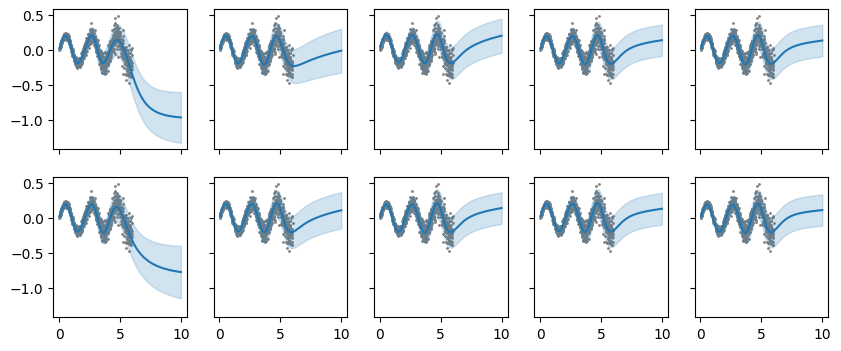

In [169]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True, sharey=True)

for i, beta in enumerate([0, 0.25, 0.5, 0.75, 1]):
    for j in range(2):
        ax = axs[j,i]

        ax.scatter(x_tensor, y_tensor, color='grey', s=1)

        mean = results[beta][j][0]

        stdev = np.sqrt(results[beta][j][1])

        ax.plot(x_test_tensor, mean)
        ax.fill_between(x_test_tensor.squeeze(), (mean - 2*stdev).squeeze(), (mean + 2*stdev).squeeze(), alpha=0.2, color='tab:blue')
